# Earth Engine API
Author: Connor Finn <br>
Date: May 28, 2020 <br>

Description: This is a script used to work with the google earth engine api. <dir>
    * Image Visualization: In this section, we display an image on a map, and through iPython
    * Collecting a range of images: This is done in 2 ways
        + Collecting a range of image objects  ~ doing some light data manipulation with them
        + Collecting an imageCollection object ~ want to be able to map functions to these!
         
    * TimeLapse Creations
        + As of now, I am only able to follow the tutorial.
        + I would love to be able to apply this to our region.

## The First step is to set up your workspace. If you run into trouble with this, ping me on slack ~ I had to make a few changes locally to get the earth engine api working.

Note: origionally the authenticate function worked only on google collab (i.e. not locally) to resolve this, i read this [stack_overflow](https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org) article.

In [111]:
import ee          # pip install 
from IPython.display import Image
import folium   # for use in map graphics

# Trigger the authentication flow.
ee.Authenticate()


Enter verification code: 4/0wG63-gZOJSNCRv_EjR46RrQNnDw-jPCvMNjyxnq37CgAyHAFq3XKCM

Successfully saved authorization token.


# Image Visualization
This [documentation](https://developers.google.com/earth-engine/image_info) is used for this section.

In [35]:
ee.Initialize()
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044035_20140318') # SF Bay area again
ndwi = image.normalizedDifference(['B3', 'B5'])  #Compute ND water index

In [36]:
image = ee.Image('LANDSAT/LC08/C01/T1/LC08_044034_20140318')
bands = image.bandNames()
bands.getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']

### Map_Display class 
This is a class that will display an image over a Folium Map

In [113]:
# I would Like to make my own class for this.
class Map_Display():

    def __init__(self , location , zoom , height  ):
      self.m =  folium.Map(location= location , zoom_start = zoom)


    def add_ee_layer(self, ee_image_object, vis_params, name):
        map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
        folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = "Map Data © Google Earth Engine",
        name = name,
        overlay = True,
        control = True
        ).add_to(self.m)

    def add_child(self , child_object):
      self.m.add_child(child_object)

    def show_map(self):
      display(self.m)


### Test out the map class

In [114]:

# Test it out
md = Map_Display([37.2, -121] , zoom = 8 , height = 500)

image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

ndwi = image.normalizedDifference(['B3', 'B5'])  # Water index
ndvi = image.normalizedDifference(['B5', 'B4'])  # Land index

# Set visualization parameters.
vis_params_W = {
  'min': 0.5,
  'max': 1.0,
  'palette': ['00FFFF', '0000FF']}

vis_params_V = {
  'min': -1,
  'max': 1,
  #'palette': ['#d73027', '#f46d43', '#fdae61','#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']
  #'palette': ['blue', 'white', 'green']
    'palette': ['blue' , 'white' , 'green']
  }


# # Add the water index model to the map object.
md.add_ee_layer(ndwi.updateMask(ndwi.gt(0)), vis_params_W, 'NDWI')

# # Add the vegetation index model to the map object.
md.add_ee_layer(ndvi, vis_params_V, 'NDVI')


# # Add a layer control panel to the map.
#md.add_child(folium.LayerControl())

new = ee.Image('LANDSAT/LC08/C01/T1/LC08_044034_20140318').select('B8')

# path 44, row 34 -> 3 digits for each!!

# edge detection using the ee provided kernel
canny = ee.Algorithms.CannyEdgeDetector(image = new, threshold = 100, sigma= 1)  # perform edge detection
hough = ee.Algorithms.HoughTransform(canny, 256, 600, 100)  # extracts lines from the canny result
#md.add_ee_layer(hough, {}, 'hough')



md.show_map()


### Display Image with iPython
Below is a workflow for displaying an image with iPython.  T

In [120]:
parameters = {'min': -1.0, # value which is mapped to 0
              'max': 1.0,  # value which is mapped to 255
              'dimensions': 768,   # size of the image 
              'bands': ['nd'],     # The bands we select
              'palette': ['blue', 'white', 'green'],  # pretty sure you only use a palette for 
              #'region': ee.Geometry.Rectangle([-74.04, 40.69, -73.82, 40.94])   # Note this region is for nyc
}
image1 = ndwi
display(Image(url = image1.getThumbUrl(parameters)))

# Get a Large Range of Images

### First Image Objects. 
     The function below will return a list of images

In [121]:
def get_images(path_list , row_list , satelite , start_date , end_date , max_cloud_percentage):
    
    # get image collection object
    coll = ee.ImageCollection(satelite)\
        .filterDate(start_date, end_date)\
        .filter(ee.Filter.inList('WRS_PATH', path_list))\
        .filter(ee.Filter.inList('WRS_ROW', row_list))\
        .filter(ee.Filter.lt('CLOUD_COVER' , max_cloud_percentage))  # note ~ not less than or equal to

    # get image_id's
    image_ids = list( map( lambda x : x['id'] , coll.getInfo()['features'] ) ) 
    
    # get image objects
    images = list( map( lambda x: ee.Image(x) , image_ids ) )
    
    return images


### Try it out
This will get a list of images from NYC, from the years 2014 to 2020. (Note Landsat 8 only goes back to 2013)

In [123]:
p = [14]
r = [32]
sat = 'LANDSAT/LC08/C01/T1'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 10
image_list = get_images(p, r, sat, sd, ed, cc)

## Light Data Manipulation for these images

### Get a Histogram of the Data

(array([1059., 3063., 2009., 1209.,  784.,  394.,  211.,  806.,  425.,
          19.]),
 array([-0.55299221, -0.47549813, -0.39800405, -0.32050998, -0.2430159 ,
        -0.16552182, -0.08802774, -0.01053366,  0.06696042,  0.1444545 ,
         0.22194858]),
 <a list of 10 Patch objects>)

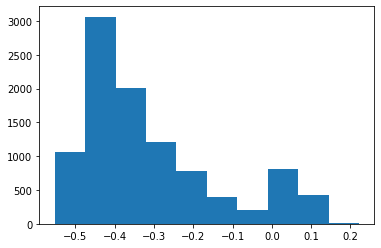

In [125]:
image = image_list[0]  # Select an image
ndwi = image.normalizedDifference(['B3', 'B5'])  #Compute ND water index

# Get 10000 random pixels
ndwi_dict = ndwi.sample(numPixels = 10000).reduceColumns(ee.Reducer.toList().repeat(1), ['nd']) 
# Build the histogram
ndwi_list = ee.List(ndwi_dict.get('list'))
ndwi_data = ndwi_list.getInfo()

#Useful to get a sense of where the vegetation or water levels are on average accross an image
import matplotlib.pyplot as plt
plt.hist(ndwi_data[0])

### Function that takes in a list of images, and returns a list of Ndwi images

In [126]:
def get_ndwi(image_list):
    return list( map( lambda x: x.normalizedDifference(['B5', 'B4']) , image_list))


ndwi_list = get_ndwi(image_list)

### Display the ndwi image using iPython method

In [127]:

parameters = {'min': -1.0,
              'max': 1.0,
              'dimensions': 768,
              'bands': ['nd'],
              'palette': ['blue', 'white', 'green'],
              'region': ee.Geometry.Rectangle([-74.04, 40.69, -73.82, 40.94])
}
image1 = ndwi_list[0]
display(Image(url = image1.getThumbUrl(parameters)))

# Image Collection Objects

In [128]:
def get_imagecollection(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
    coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))

    return coll

def getndvi(image):
    return image.normalizedDifference(['B5','B4'])
 
def conditional(image):
    return ee.Algorithms.If(ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0))

In [129]:
# This function adds a band with the ndvi.

def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B5', 'B4']))



### I have been unable to map to an image collectg. The addNDVI function works on a single image, but I cannot map it accross an entire image collection


In [130]:
imagecollection = get_imagecollection(p, r, sat, sd, ed, cc)

In [131]:
imagecollection = imagecollection.map(algorithm=addNDVI)

In [132]:
def extract_images(coll):
    
    # get image_id's
    image_ids = list( map( lambda x : x['id'] , coll.getInfo()['features'] ) ) 
    
    # get image objects
    images = list( map( lambda x: ee.Image(x) , image_ids ) )
    return images

In [273]:
ims = extract_images(imagecollection)
len(ims)

34

In [274]:
one = ims[0]

In [282]:
one.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'BQA',
 'nd',
 'nd_1',
 'nd_2']

In [281]:
one = addNDVI(one)

# Build a Timelapse

## Tutorial
blog](http://www.acgeospatial.co.uk/building-time-lapse-imagery-gee/) <dir>

In [138]:

from ee import batch


## define your collection
collection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')

#Dubai Path and Row
path = collection.filter(ee.Filter.eq('WRS_PATH', 160))
pathrow = path.filter(ee.Filter.eq('WRS_ROW', 43))
 
##Filter cloudy scenes.
clouds = pathrow.filter(ee.Filter.lt('CLOUD_COVER', 5))

## select the bands, we are going for true colour... but could be any!
bands = clouds.select(['B3' , 'B2' , 'B1' ])

##make the data 8-bit.
def convertBit(image):
    return image.multiply(512).uint8()  

## call the conversion    
outputVideo = bands.map(lambda x: x.multiply(512).uint8())

print("about to build video")

#Export to video.
# Dubai
out = batch.Export.video.toDrive(outputVideo, description='dubai_video_connor', dimensions = 720, framesPerSecond = 2, region=([55.6458,25.3540], [54.8135,25.3540],[54.8135,24.8042],[55.6458,24.8042]), maxFrames=10000)

## process the image
process = batch.Task.start(out)

print("process sent to cloud")

about to build video
process sent to cloud


## The above tutorial sends the timelapse to your drive. To visualize it imediately, copy the link from below into your browser. 

In [139]:

band_list = ['B1' , 'B2' , 'B3']
region = [[55.6458,25.3540], [54.8135,25.3540],[54.8135,24.8042],[55.6458,24.8042]]

vid = outputVideo.getVideoThumbURL({
              'dimensions': 720,
              'bands': band_list, 
              'framesPerSecond' : 2,
              'region' : ee.Geometry.Polygon([region]) })
vid

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/ce9b1658a082cae017631a7bd159e336-b850a1e7b55b1e5ef11ac0151886b1ad:getPixels'

# Movie Building Class:
this class I am building based off the tutorial provided by this [blog](http://www.acgeospatial.co.uk/building-time-lapse-imagery-gee/) <dir>
    
    This still needs to be fixed. I can currently only replicate the blog and am undable to switch to nyc scenery.

In [133]:
class Time_Lapse_Builder():
    
    
    def __init__(self):
        self.collection = None
        

    def get_collection(self, path_list , row_list , satelite , start_date , end_date , max_cloud_percentage):

        # get image collection object
        coll = ee.ImageCollection(satelite)\
            .filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER' , max_cloud_percentage))  # note ~ not less than or equal to

        self.collection = coll
        
        
    def build_movie(self , region , band_list , file_name):
        from ee import batch
        # select the bands we want to video
        bands = self.collection.select(band_list)

        # call the conversion    
        outputVideo = bands.map(lambda x: x.multiply(512).uint8())

        #Export to video.
        out = batch.Export.video.toDrive( outputVideo, description= file_name, dimensions = 720,\
                            framesPerSecond = 2, region= region, maxFrames=10000)

        # process the video
        process = batch.Task.start(out)
        
    def build_movie_url(self , region , band_list):
        bands = self.collection.select(band_list)
        outputVideo = bands.map(lambda x: x.multiply(512).uint8())
        vid = outputVideo.getVideoThumbURL({
              'dimensions': 720,
              'bands': band_list, 
              'framesPerSecond' : 2,
               'region' : ee.Geometry.Polygon([region]) 
        })
    
        return vid
        
    

### Try out the movie class

In [140]:
mc = Time_Lapse_Builder()

# Try it out
p = [14]
r = [32]
sat = 'LANDSAT/LC08/C01/T1'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 10
mc.get_collection(p, r, sat, sd, ed, cc)
nyc_bounding_box = ([-74.05107266542949,40.70551138579543],\
 [-73.97931820986308,40.68650945998215],\
 [-73.89623410341777,40.789523346375084],\
 [-73.98961789248027,40.81603138653903])

#region = ee.Geometry.Rectangle([-74.04, 40.69, -73.82, 40.94])
band_list = ['B4', 'B3', 'B2']
file_name = 'New_York_TimeLapse'
mc.build_movie(nyc_bounding_box, band_list , file_name)

In [141]:
mc.build_movie_url(nyc_bounding_box, band_list)

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/cf34e2fea0a37c9c25eb8de66ffd427e-8e4298e46b45200dff186dfe2c7b3ea2:getPixels'

## Simply replicate the tutorial with nyc.
This is not working either!!


In [142]:

from ee import batch


## define your collection
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1')

#Dubai Path and Row
path = collection.filter(ee.Filter.eq('WRS_PATH', 14))
pathrow = path.filter(ee.Filter.eq('WRS_ROW', 32))
 
##Filter cloudy scenes.
clouds = pathrow.filter(ee.Filter.lt('CLOUD_COVER', 10))

## select the bands, we are going for true colour... but could be any!
bands = clouds.select(['B1' , 'B2' , 'B3' ])

##make the data 8-bit.
def convertBit(image):
    return image.multiply(512).uint8()  

## call the conversion    
outputVideo = bands.map(lambda x: x.multiply(512).uint8())

print("about to build video")

#Export to video.
# Dubai
#batch.Export.video.toDrive(outputVideo, description='nyc', dimensions = 720, framesPerSecond = 2, region=nyc_bounding_box, maxFrames=10000)
batch.Export.video.toDrive(outputVideo, description='nyc', dimensions = 720, framesPerSecond = 2,  maxFrames=10000)

## process the image
#process = batch.Task.start(out)

print("process sent to cloud")

about to build video
process sent to cloud


### Debugging
The images do contain nyc so there is something else going on

In [143]:
parameters = {'min': 0,      # This is the value you map to 0
              'max': 16000,   # This is the value you map to 255
              'dimensions': 768,
              'bands': ['B1' , 'B2' , 'B3'],
              'region': ee.Geometry.Rectangle([-74.06, 40.60, -73.82, 40.94]),

}
# get image_id's
image_ids = list( map( lambda x : x['id'] , clouds.getInfo()['features'] ) ) 
    
    # get image objects
images = list( map( lambda x: ee.Image(x) , image_ids ) )
image1 = images[0]
display(Image(url = image1.getThumbUrl(parameters)))